### Libs

In [1]:
import requests
import json
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

### Data

In [2]:
with open('dataset\cvrp_castanhal_completo.json') as json_file:
    raw_data = json.load(json_file)

In [3]:
raw_data.keys()

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])

In [4]:
raw_data["origin"]

{'lng': -47.93317089927402, 'lat': -1.2923387357484621}

In [5]:
raw_data["vehicle_capacity"]

180

In [6]:
raw_data["deliveries"][0]

{'id': '245aed8b07925496f14cc83f85a95318',
 'point': {'lng': -48.083796008609376, 'lat': -1.3859328704379723},
 'size': 8}

### General Class

In [7]:
class Coordinate:
    def __init__(self, lat, lng):
        self.lat = lat
        self.lng = lng

In [8]:
class Delivery:
    def __init__(self, raw_delivery, index):
        self.id = index+1
        self.point = Coordinate(str(raw_delivery["point"]["lat"]), str(raw_delivery["point"]["lng"]))
        self.size = raw_delivery["size"]

In [9]:
class DepotNet:
    def __init__(self, raw_data):
        self.name = raw_data["name"]
        self.region = raw_data["region"]
        self.origin = Coordinate(str(raw_data["origin"]["lat"]), str(raw_data["origin"]["lng"]))
        self.vehicle_capacity = raw_data["vehicle_capacity"]
        self.deliveries = [Delivery(raw_data["deliveries"][i], i) for i in range(len(raw_data["deliveries"]))]

### Tabu Search

In [10]:
#Class Tabu Search for the problem of the CVRP
class TabuSearch:
    def __init__(self, depot_net, max_iterations, n_neighbors, tabu_list_size):
        self.depot_net = depot_net
        self.max_iterations = max_iterations
        self.n_neighbors = n_neighbors
        self.tabu_list_size = tabu_list_size
        self.solution = []
        self.best_solution = []
        self.best_solutions = pd.DataFrame(columns=[f"x_{i}" for i in range(len(self.depot_net.deliveries))]+["y"])
        self.best_neighborhood = pd.DataFrame(columns=[f"x_{i}" for i in range(len(self.depot_net.deliveries))]+["y"])
        self.tabu_list = []
        self.run()

    def generate_solution_initial(self):
        n = len(self.depot_net.deliveries)
        solution = np.random.choice([i for i in range(n)], n, replace=False)
        return [self.depot_net.deliveries[idx].id for idx in solution]
    
    def udpate_best_solutions(self, solution, solution_cost):
        s = pd.Series([self.depot_net.deliveries[idx-1].id for idx in solution]+[solution_cost],index=[f"x_{i}" for i in range(len(solution))]+["y"])
        self.best_solutions = self.best_solutions.append(s, ignore_index=True)
        df = self.best_solutions.iloc[:, :-1].astype(int)
        df["y"] = self.best_solutions["y"]
        self.best_solutions = df

    def udpate_best_neighborhood(self, solution, solution_cost):
        s = pd.Series([self.depot_net.deliveries[idx-1].id for idx in solution]+[solution_cost],index=[f"x_{i}" for i in range(len(solution))]+["y"])
        self.best_neighborhood = self.best_neighborhood.append(s, ignore_index=True)
        df = self.best_neighborhood.iloc[:, :-1].astype(int)
        df["y"] = self.best_neighborhood["y"]
        self.best_neighborhood = df
    
    def solution_cost(self, solution, save=False):
        solution_cost = 0
        route_list = [f"{self.depot_net.origin.lng},{self.depot_net.origin.lat}"]
        weight = 0
        for delivery in [self.depot_net.deliveries[idx-1] for idx in solution]:
            weight += delivery.size
            if weight <= self.depot_net.vehicle_capacity:
                route_list.append(f"{delivery.point.lng},{delivery.point.lat}")
            else:
                route_list.append(f"{self.depot_net.origin.lng},{self.depot_net.origin.lat}")
                route_list.append(f"{delivery.point.lng},{delivery.point.lat}")
                weight = 0
        route_list.append(f"{self.depot_net.origin.lng},{self.depot_net.origin.lat}")
        route_str = ";".join(route_list)
        query = f"https://router.project-osrm.org/route/v1/driving/{route_str}?overview=false"
        #print(query)
        response = requests.get(query)
        data = response.json()
        #salvar resposta da requisição em arquivo no formato json
        waypoints = data["waypoints"]
        origin = waypoints[0]['location']
        geometrys = [waypoints[i]['location'] for i in range(len(waypoints))]
        indexs_origin = [i for i in range(len(geometrys)) if geometrys[i] == origin]
        for i in range(len(indexs_origin)):
            waypoints[indexs_origin[i]]["hint"] = 0
        indexs_hint = [i for i in range(len(waypoints)) if waypoints[i]["hint"] != 0]
        for i in range(len(indexs_hint)):
            waypoints[indexs_hint[i]]["hint"] = self.best_solution[i]
        if save:
            with open('results/best_route_cvrp.json', 'w') as outfile:
                json.dump(data, outfile)
        solution_cost = data["routes"][0]["distance"]
        return solution_cost
    
    def swap(self, solution):
        i, j = np.random.choice(len(solution)-1, 2, replace=False)
        solution[i], solution[j] = solution[j], solution[i]
        return solution
    
    def diference_solutions(self, solution, best_neighbor):
        indexs = [i for i in range(len(solution)) if solution[i] != best_neighbor[i]]
        return indexs
    
    def generate_neighbors(self, iteration):
        neighbors = []
        neighbors_cost = []
        for _ in range(self.n_neighbors):
            neighbor = self.swap(self.solution.copy())
            while neighbor in neighbors:
                neighbor = self.swap(self.solution.copy())
            neighbor_cost = self.solution_cost(neighbor)
            if neighbors_cost == []:
                neighbors.append(neighbor)
                neighbors_cost.append(neighbor_cost)
            else:
                for k in range(len(neighbors_cost)):
                    if neighbor_cost < neighbors_cost[k]:
                        neighbors.insert(k, neighbor)
                        neighbors_cost.insert(k, neighbor_cost)
                        break
                    if k == len(neighbors_cost)-1:
                        neighbors.append(neighbor)
                        neighbors_cost.append(neighbor_cost)
        self.update_tabu_list(neighbors, neighbors_cost, iteration)
    
    def update_tabu_list(self, neighbors, neighbors_cost, iteration):
        if neighbors_cost[0] < self.solution_cost(self.best_solution):
            if len(self.tabu_list) == self.tabu_list_size:
                self.tabu_list.pop(0)
            self.tabu_list.append(self.diference_solutions(self.solution, neighbors[0]))
            self.solution = neighbors[0]
            #print(f'Mudou para melhor na iteração {iteration}')
            self.best_solution = neighbors[0]
            self.udpate_best_neighborhood(neighbors[0], neighbors_cost[0])
        else:
            for l in range(self.n_neighbors):
                indexs_swap = self.diference_solutions(self.solution, neighbors[l])
                if indexs_swap in self.tabu_list:
                    continue
                else:
                    if len(self.tabu_list) == self.tabu_list_size:
                        self.tabu_list.pop(0)
                    self.tabu_list.append(indexs_swap)
                    self.solution = neighbors[l]
                    #print(f'Mudou para pior na iteração {iteration}')
                    self.udpate_best_neighborhood(neighbors[l], neighbors_cost[l])
                    break
                
    def progress_bar(self, i):
        #clear_output(wait=True)
        pc = int(i/self.max_iterations*100)
        logic_char = 0 if i == 1 else int(pc/2)
        print(f"Executando iteração {i}/{self.max_iterations}:|{'█' * logic_char + '.' * (50 - logic_char)}|{pc}%",
              end='\r', flush=True)

    def run(self):
        self.solution = self.generate_solution_initial()
        self.best_solution = self.solution
        initial = [self.solution, self.solution_cost(self.solution)]
        for i in range(self.max_iterations):
            self.progress_bar(i+1)
            self.generate_neighbors(i)
            self.udpate_best_solutions(self.best_solution, self.solution_cost(self.best_solution))
        #limpar a tela
        clear_output(wait=True)
        #print(f'Solução inicial:\n{initial[0]}\nCusto: {initial[1]}')
        #print(f'Após {i+1} iterações, temos:')
        #print(f'Solução Final:\n{self.best_solution}\nCusto: {self.solution_cost(self.best_solution)}')

### Run

In [11]:
depot_net = DepotNet(raw_data)
max_iterations = 100
n_neighbors = 10
tabu_list_size = 5
max_executions = 10
tabu_search_list = []

for i in range(max_executions):
    print(f'Execução {i+1}/{max_executions}')
    #Criar instância do algoritmo (com execução automática)
    tabu_search_list.append(TabuSearch(depot_net, max_iterations, n_neighbors, tabu_list_size))

Execução 10/10


In [12]:
#verificar melhor execução
best_solution = tabu_search_list[0].best_solution
best_cost = tabu_search_list[0].solution_cost(best_solution)
best_tabu = tabu_search_list[0]
for i in range(1, len(tabu_search_list)):
    if tabu_search_list[i].solution_cost(best_solution) < best_cost:
        best_tabu = tabu_search_list[i]

In [60]:
mean_neighborhood = []
std_neighborhood = []
mean_solutions = []
std_solutions = []
n = len(best_tabu.best_neighborhood["y"])

#médias e desvios padrão entre os melhores das vizinhanças
cost1 = []
for tabu in tabu_search_list:
    cost1.append(tabu.best_neighborhood["y"].values)
for i in range(n):
    mean = []
    for j in range(len(cost1)):
        mean.append(cost1[j][i])
    mean_neighborhood.append(np.mean(mean))
    std = []
    for j in range(len(cost1)):
        std.append(cost1[j][i])
    std_neighborhood.append(np.std(std))

#médias e desvios padrão entre os melhores globais
cost2 = []
for tabu in tabu_search_list:
    cost2.append(tabu.best_solutions["y"].values)
for i in range(n):
    mean = []
    for j in range(len(cost2)):
        mean.append(cost2[j][i])
    mean_solutions.append(np.mean(mean))
    std = []
    for j in range(len(cost2)):
        std.append(cost1[j][i])
    std_solutions.append(np.std(std))

df_st_neighborhood = pd.DataFrame([mean_neighborhood, std_neighborhood], index=['mean','std']).T
df_st_solutions = pd.DataFrame([mean_solutions, std_solutions], index=['mean','std']).T

print(f'-------------- Avaliação geral do modelo ----------------')
print(f'Média entre os melhores das vizinhanças: {np.mean(df_st_neighborhood["mean"]):.2f}')
print(f'Desvio padrão entre os melhores vizinhanças: {np.std(df_st_neighborhood["std"]):.2f}')
print(f'Média de custo das soluções: {np.mean(df_st_solutions["mean"]):.2f}')
print(f'Desvio padrão das soluções: {np.std(df_st_solutions["std"]):.2f}')

-------------- Avaliação geral do modelo ----------------
Média entre os melhores das vizinhanças: 231837.06
Desvio padrão entre os melhores vizinhanças: 10725.52
Média de custo das soluções: 230477.72
Desvio padrão das soluções: 10725.52


### Analysis

##### Best neighborhood (Best execution)

In [61]:
print(f'Melhores soluções das vizinhanças:')
display(best_tabu.best_neighborhood)
best_cost_neighborhood = best_tabu.best_neighborhood["y"].min()
index_best_neighborhood = best_tabu.best_neighborhood.loc[best_tabu.best_neighborhood["y"] == best_cost_neighborhood].index
print(f'Melhor(res) solução(ões) apresentada(s) no(s) índece(s):\n{index_best_neighborhood.astype(int).tolist()}')

Melhores soluções das vizinhanças:


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,y
0,7,27,13,15,10,23,35,31,21,28,...,9,11,17,12,32,30,22,3,1,452088.3
1,7,27,13,19,10,23,35,31,21,28,...,9,11,17,12,32,30,22,3,1,448886.0
2,7,27,13,19,10,23,35,31,21,28,...,9,11,17,12,32,30,22,3,1,385203.0
3,7,27,13,19,10,23,35,31,21,28,...,9,11,17,12,32,30,25,3,1,384081.4
4,34,27,13,19,10,23,35,31,21,28,...,9,11,17,12,32,30,25,3,1,382600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16,33,13,19,25,11,21,8,22,7,...,12,14,10,28,18,26,9,3,1,219524.1
96,16,33,13,19,25,11,21,8,22,7,...,12,14,10,28,18,26,9,3,1,219402.7
97,16,33,13,19,25,11,21,8,22,15,...,12,14,10,28,18,26,9,3,1,220488.3
98,16,18,13,19,25,11,21,8,22,15,...,12,14,10,28,33,26,9,3,1,222845.3


Melhor(res) solução(ões) apresentada(s) no(s) índece(s):
[94]


##### Best solutions (Best execution)

In [62]:
print(f'Melhores soluções globais por iteração:')
display(best_tabu.best_solutions)
index_best_solutions = best_tabu.best_solutions.loc[best_tabu.best_solutions["y"] == best_tabu.best_solutions["y"].min()].index
print(f'Melhor(res) solução(ões) apresentada(s) no(s) índece(s):\n{index_best_solutions.astype(int).tolist()}')

Melhores soluções globais por iteração:


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,y
0,7,27,13,15,10,23,35,31,21,28,...,9,11,17,12,32,30,22,3,1,452088.3
1,7,27,13,19,10,23,35,31,21,28,...,9,11,17,12,32,30,22,3,1,448886.0
2,7,27,13,19,10,23,35,31,21,28,...,9,11,17,12,32,30,22,3,1,385203.0
3,7,27,13,19,10,23,35,31,21,28,...,9,11,17,12,32,30,25,3,1,384081.4
4,34,27,13,19,10,23,35,31,21,28,...,9,11,17,12,32,30,25,3,1,382600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16,26,13,19,25,11,21,8,22,7,...,12,14,10,28,18,33,9,3,1,219256.1
96,16,26,13,19,25,11,21,8,22,7,...,12,14,10,28,18,33,9,3,1,219256.1
97,16,26,13,19,25,11,21,8,22,7,...,12,14,10,28,18,33,9,3,1,219256.1
98,16,26,13,19,25,11,21,8,22,7,...,12,14,10,28,18,33,9,3,1,219256.1


Melhor(res) solução(ões) apresentada(s) no(s) índece(s):
[94, 95, 96, 97, 98, 99]


##### Graphic minimization

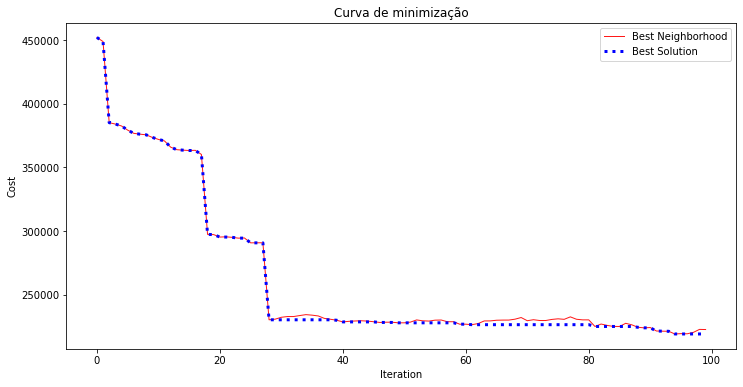

In [87]:
#Convergência na melhor execução
x = np.arange(0, max_iterations, 1)
y1 = best_tabu.best_neighborhood["y"].values
y2 = best_tabu.best_solutions["y"].values

fig, ax = plt.subplots()
fig.set_size_inches(12,6)
lines = ax.plot(x, y1, color='red', lw=1, alpha=0.9)
ax.plot(x, y2, color='blue', lw=3, linestyle=':')
ax.set_title('Curva de minimização')
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost')
ax.legend(['Best Neighborhood', 'Best Solution'])
plt.savefig('results/graphic_convergence_best', dpi = 300)
plt.show()

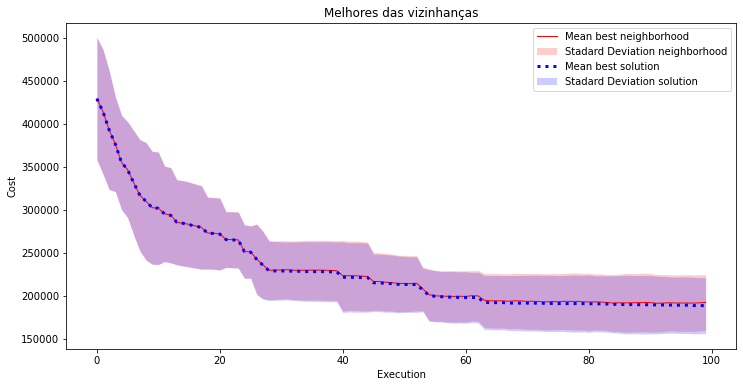

In [93]:
#Convergência entre as execuções 
x = np.arange(0, max_iterations, 1)
y1 = df_st_neighborhood["mean"].values
y1err = df_st_neighborhood["std"].values
y2 = df_st_solutions["mean"].values
y2err = df_st_solutions["std"].values

colors = ['red', 'blue', 'green', 'orange', 'black', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 6))
ax0.plot(x, y1, color='red', lw=1)
ax0.fill_between(x, y1-y1err, y1+y1err, color='red', alpha=0.2,  linewidth=0.0)
ax0.set_title('Melhores das vizinhanças')
ax0.set_xlabel('Execution')
ax0.set_ylabel('Cost')
ax0.plot(x, y2, color='blue', lw=3, linestyle=':')
ax0.fill_between(x, y2-y2err, y2+y2err, color='blue', alpha=0.2, linewidth=0.0)
ax0.legend(['Mean best neighborhood','Stadard Deviation neighborhood','Mean best solution','Stadard Deviation solution'])
plt.savefig('results/graphic_convergence_executions', dpi = 300)
plt.show()

##### Response request OSRM

In [89]:
#Pegando dados da melhor solução
best_tabu.solution_cost(best_tabu.best_solution, save=True)
with open('results/best_route_cvrp.json', 'r') as outfile:
    data = json.load(outfile)
    #pontos de rota
    waypoints = data['waypoints']
    hints = [waypoints[i]['hint'] for i in range(len(waypoints))]
    geometrys = [waypoints[i]['location'] for i in range(len(waypoints))]
    geometrys = [[geometrys[i][1], geometrys[i][0]] for i in range(len(geometrys))]
    #distâncias entre cada ponto de rota
    legs = data['routes'][0]['legs']
    distances_legs = [legs[i]['distance'] for i in range(len(legs))]
#pontos da rota em que são o depósito
indexs_origin = [i for i in range(len(waypoints)) if waypoints[i]['hint'] == 0]

In [90]:
print(f'Quantidades de rotas calculadas: {len(indexs_origin)-1}')
for i in range(len(indexs_origin)-1):
    peso = 0
    rota = ''
    for hint in hints[indexs_origin[i]+1:indexs_origin[i+1]]:
        peso += raw_data["deliveries"][hint-1]["size"]
        rota += f' -> {hint}'
    print(f'\nRota {i+1}: 0' + rota + f' -> 0')
    print(f'Peso máximo atingido: {peso}kg')
    distance_route = sum(distances_legs[indexs_origin[i]:indexs_origin[i+1]])
    print(f'Distância: {distance_route:.2f}km')

Quantidades de rotas calculadas: 2

Rota 1: 0 -> 16 -> 26 -> 13 -> 19 -> 25 -> 11 -> 21 -> 8 -> 22 -> 7 -> 6 -> 2 -> 5 -> 4 -> 20 -> 34 -> 32 -> 31 -> 29 -> 30 -> 35 -> 23 -> 27 -> 17 -> 24 -> 15 -> 12 -> 14 -> 10 -> 28 -> 18 -> 33 -> 0
Peso máximo atingido: 174kg
Distância: 125449.40km

Rota 2: 0 -> 9 -> 3 -> 1 -> 0
Peso máximo atingido: 20kg
Distância: 93806.70km


##### Map

In [91]:
import folium

#intanciando mapa
tiles = ['OpenStreetMap','CartoDB positron','Stamen toner','Stamen Terrain']
mapa = folium.Map(location=geometrys[0], zoom_start=12, tiles=tiles[1])

#marcador de cada ponto da rota
for i in range(len(geometrys)):
    folium.Marker(geometrys[i], popup=f'Ponto {hints[i]}').add_to(mapa)

#marcador do depósito, ponto incial/final
folium.CircleMarker(geometrys[0], radius=10, popup='Depósito', color='red', fill=True).add_to(mapa)

color = ['red', 'blue', 'green', 'yellow', 'black', 'purple', 'orange', 'brown', 'pink', 'gray']
#criar linhas poligonais entre as rotas
for i in range(len(indexs_origin)-1):
    folium.PolyLine(geometrys[indexs_origin[i]:indexs_origin[i+1]+1], color=color[i], weight=2, opacity=0.7).add_to(mapa)

mapa

In [92]:
#salvar mapa
mapa.save('results/mapa_cvrp.html')